# Natural Language Processing: An Application in Public Policy

## by Ancil Crayton

The purpose of this notebook is to guide readers through the process of analyzing the FOMC statements, estimating topic models (i.e. extracting topics), tools for model selection, and calculating measures of negativity and uncertainty within the topic models. This notebook outputs the topic weights and probabilities and proportions of negativite and uncertain language within the statements into a csv file. Those weights and proportions are then used in a regression analysis.

## Part 1: Text Preprocessing

In [1]:
# TRY RUNNING CELL BELOW! If it does not work, create a virtual environment, uncomment the code below and run to install dependencies
#!pip install -r requirements.txt

In [2]:
# Standard libraries for data frames, arrays, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import seaborn as sns
sns.set(style="white")
%matplotlib inline

# Import Scikit Learn for preprocessing tools and algorithms
import sklearn

# Import library for setting dates
import datetime as dt

# Import library for reading pdf files
import PyPDF2

# Import wordclouds for visualizing topics
import wordcloud

# Import gensim library for calculating coherence measures
import gensim

# Import natural language package to remove stopwords and lemmatize terms
import nltk

# Import digits module to filter out numbers
#import re
import string

# Import statsmodels for statistical analysis
import statsmodels

# Import pandas_datareader to get financial data from Yahoo
import pandas_datareader

In [3]:
# Import in unprocessed statements scraped from Scrapy into a csv file
data = pd.read_csv('data/statements.csv', skipinitialspace=True)
data.head(10)

,Date,Statement
0,10/05/1999,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
1,18/05/1999,\r\r\r\r\r\r\r\r\r\r\t\tWhile the FOMC did not...
2,30/06/1999,\r\r\r\r\r\r\r\r\tLabor markets have continued...
3,24/08/1999,\r\r\r\r\r\r\r\r\t With financial markets fun...
4,16/11/1999,\r\r\r\r\r\r\r\r\tThe Federal Open Market Comm...
5,21/12/1999,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
6,02/02/2000,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
7,10/03/2000,\r\r\r\r\r\r\r\r\r\rThe Federal Open Market Co...
8,21/03/2000,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
9,16/05/2000,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...


In [4]:
statements = data['Statement']
statements.head(10)

0    \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
1    \r\r\r\r\r\r\r\r\r\r\t\tWhile the FOMC did not...
2    \r\r\r\r\r\r\r\r\tLabor markets have continued...
3    \r\r\r\r\r\r\r\r\t  With financial markets fun...
4    \r\r\r\r\r\r\r\r\tThe Federal Open Market Comm...
5    \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
6    \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
7    \r\r\r\r\r\r\r\r\r\rThe Federal Open Market Co...
8    \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
9    \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
Name: Statement, dtype: object

### The text preprocessing steps
Text preprocessing is an important part of the NLP pipeline as it allows us to get more information out of our documents and discard any irrelevant information. The steps you take for preprocessing are dependent on the application, however there are some common steps that are normally taken in many NLP applications.

The preprocessing steps I take here are:
- Lowercasing
- Remove extra spacing
- Remove punctuation
- Removing digits
- Remove stopwords
- Lemmatization

An example of the process for an FOMC statement:

<img src="images/preprocessing.png" alt="FOMC Statement, May 10, 1999" title="Text Preprocessing Example" />

In [5]:
# Import tools to tokenize, remove stopwords, and lemmatize (or stem) words
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords') # download collection of stopwords from NLTK
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
nltk.download('wordnet') # download wordnet dictionary of lemmas
from nltk.stem import WordNetLemmatizer
from string import digits

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ancilcrayton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ancilcrayton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Lowercase, remove digits, and lemmatize statements
n=len(statements)
raw_doc_length = list(range(0, n))
doc_length = list(range(0, n))
#porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for i in range(n):
    # Lowercase the statement
    lowercase = statements[i].lower()
    # Tokenize the statement
    tokenize = CountVectorizer().build_tokenizer()(lowercase)
    # Count raw number of words
    raw_doc_length[i] = len(tokenize)
    # Remove digits
    remove_digits = [w for w in tokenize if not w.isdigit()]
    # Remove stopwords
    no_stopwords = [w for w in remove_digits if not w in stopwords.words('english')]
    # Lemmatize
    lemma = [lemmatizer.lemmatize(w) for w in no_stopwords]
    # Count preprocessed words
    doc_length[i] = len(lemma)
    # Join each statement back together
    statements[i] = ' '.join(lemma)

In [7]:
# Example of processed statement
statements[0]

'federal open market committee decided today leave target federal fund rate unchanged strengthening productivity growth fostering favorable trend unit cost price much recent information suggests trend sustained nonetheless growth demand continued outpace supply evidenced decreasing pool available worker willing take job circumstance federal open market committee need especially alert month ahead potential cost increase significantly excess productivity manner could contribute inflation pressure undermine impressive performance economy background committee adopted directive biased toward possible firming policy going forward committee member emphasized directive signify commitment near term action committee need evaluate additional information balance aggregate supply demand condition financial market'

In [8]:
# Save dates in a list
dates=data['Date']
x = [dt.datetime.strptime(d,'%d/%m/%Y').date() for d in dates]

In [9]:
# Transform raw document length list into a numpy array
raw_doc_length = np.asarray(raw_doc_length)

In [10]:
# Transform preprocessed document length list into a numpy array
doc_length = np.asarray(doc_length)

/Users/ancilcrayton/envs/nlp_public_policy/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/ancilcrayton/envs/nlp_public_policy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3128: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


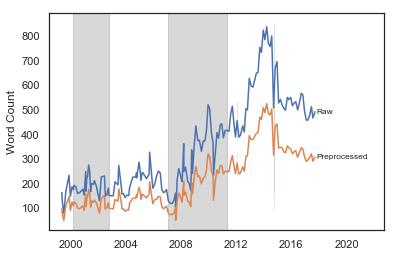

In [11]:
# Create plot of document length
data = pd.DataFrame({'Year': x, 'Raw':raw_doc_length, 'Preprocessed':doc_length})
ax1=sns.lineplot(x='Year', y='Raw', data=data)
ax2=sns.lineplot(x='Year', y='Preprocessed', data=data)
ax1.set(xlabel ='', ylabel='Word Count')
ax2.set(xlabel ='', ylabel='Word Count')
ax1.text(x=date2num(data["Year"].iloc[-1])+30, y=data['Raw'].iloc[-1], s="Raw", 
         horizontalalignment='left', size='small', verticalalignment='center')
ax2.text(x=date2num(data["Year"].iloc[-1])+30, y=data['Preprocessed'].iloc[-1], s="Preprocessed", 
         horizontalalignment='left', size='small', verticalalignment='center')
# Shade in early 2000s crisis
ax2.axvspan(x[7], x[32], alpha=0.30, color='gray')
# Shade in global financial crisis
ax2.axvspan(x[65], x[105], alpha=0.30, color='gray')
plt.xlim(xmax=date2num(data["Year"].iloc[-1])+1826)
plt.savefig('images/document_length.png', dpi=300)
plt.show()

## Part 2: Feature Extraction

Next, we must extract features from the normalized text using the Sci-kit Learn package. We will extract them by transforming the pure text into a weighted document-term matrix. We create unigram and bigram representations. This allows us to look at the frequency of single words and contiguous pairs of words (unigram and bigram, respectively).

Our final weighted matrix is derived from the __Bag of Words Model (BOW)__. BOW is simply a matrix that collects the count of each unique term in the corpus in each document. It has the dimensions (number of documents x number of unique terms).

For a quick example, consider that we have three sentences, each representing a document:
1. I love dogs
2. I hate dogs and knitting
3. knitting is my hobby and my passion

An example of the Bag of Words model would be

<img src="images/bow.jpg" alt="Bag of Words Model" title="BoW model example" />

The Bag of Words model is a useful representation, but it can be improved upon. To make this representation more informative, we apply the term frequency-inverse document frequency weighting scheme to each element of the matrix. The idea behind this is to give the highest priority to words that occur frequently but in a low number of documents.

Term-frequency-inverse document frequency is represented by the following equation

$$ tf-idf = tf(t,d) \text{ x } idf(t, D) $$

with $tf(t,d)$ and $idf(t,D)$ representing the rewarding term frequency and penalizing document frequency terms, respectively.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
# Create unigram TF-IDF weighted matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=0.05, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(statements).toarray()
X_tfidf.shape

(159, 552)

Although we do not include them in this analysis, you could extend this analysis to include bigrams (word pairs). This can account for words commonly used together such as 'monetary policy', 'financial crisis', 'discount rate', etc.

In [14]:
# Create bigram TF-IDF weighted matrix
#bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.95)
#X1_tfidf = bigram_tfidf_vectorizer.fit_transform(statements).toarray()
#X1_tfidf.shape

## Part 3: Topic Modeling with Non-negative Matrix Factorization

<img src="images/NMF.jpg" alt="Visualization of NMF algorithm" title="Non-negative Matrix Factorization" />

- Developed by Lee and Seung (1999)
- Algorithm learns __parts-based representations__
- __W__ matrix tracks weights of topics in documents
- __H__ matrix tracks weights of unique terms in topics

Minimizes the following objective function:
$$ \dfrac{1}{2}||A - WH||_{F}^{2} = \dfrac{1}{2}\sum_{i=1}^{M}\sum_{j=1}^{N}(A_{ij}-(WH)_{ij})^{2} $$

In [15]:
# Import NMF from Scikit Learn and 
from sklearn.decomposition import NMF
from sklearn import metrics

In [16]:
# Create a function that prints the top words of a topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [17]:
# Create a function that prints the topics as a list
def print_topics(model, feature_names, n_top_words, n_components):
    topics=list(range(n_components))
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx]=[str(feature_names[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics

In [18]:
# Get the terms from the TF-IDF matrix
tfidf_feature_names_n1 = tfidf_vectorizer.get_feature_names()

In [19]:
# Estimate preliminary unigram NMF model with three topics
nmf = NMF(n_components=3, random_state=1,
          beta_loss='kullback-leibler', solver='mu', 
          max_iter=10000).fit(X_tfidf) # minimizes using kullback-leibler with unigrams
print_top_words(nmf, tfidf_feature_names_n1, 15)

Topic #0: inflation longer labor term condition policy price security fund run employment pace percent range agency
Topic #1: board growth approved action basis point discount reserve sustainable productivity belief risk demand price available
Topic #2: security credit financial reserve recovery level exceptionally purchase continue promote subdued facility billion condition housing



## Part 4: Parameter Selection for Non-negative Matrix Factorization

One of the main issues in topic modelling is deciding on the k parameter. This parameter is the number of topics to estimate in the model. Naturally, when we develop a topic model in the social sciences, we would like our topics to be defined and interpretable. Therefore, to automatically select the k parameter, we use __measures of topic coherence__. In general, topic coherence measures the semantic similarity between the top terms used to represent a topic. There exists numerous measures of coherency with the __most common measures being the $C_{UMass}$, $C_{UCI}$, and $C_{V}$__.

There exists a __distinction between extrinsic and intrinsic topic coherency measures__. Extrinsic measures use __external datasets__ to assess coherency or what we refer to as "background corpora." The argument behind these measures is that using the same dataset to assess coherency would reinforce noise or unusual word statistics. Standard measures for this is the $C_{UCI}$ and the $C_{V}$. Intrinsic measures simply use the main corpus and use empirical estimates of probabilities to define its measure. A standard intrinsic coherence measure is the $C_{UMass}$. All of these measures are openly available in the gensim package.

Since there are no suitable background sources of communication for the FOMC statements, we use $C_{UMass}$ coherency developed by Mimno et al. (2011). Specifically, it measures the ability of a higher weighted word in prediciting a lower weighted word. The equation follows

$$ C_{UMass}(w_i, w_j)^{(t)} = \dfrac{2}{N(N-1)}\sum_{i=2}^{N}\sum_{j=1}^{i-1}log\dfrac{P(w_{i}^{(t)},w_{j}^{(t)}) + \epsilon}{P(w_{j}^{(t)})} $$

In [20]:
# Retrieve modules to set corpous and get coherence. Show logging details to see progress.
from gensim import corpora, models

In [21]:
# Tokenize each statement, add terms to dictionary, and build main corpus
for i in range(n):
    statements[i] = CountVectorizer().build_tokenizer()(statements[i])
dictionary=corpora.Dictionary(statements)
corpus=[dictionary.doc2bow(doc) for doc in statements]

In [22]:
# Parameter selection using intrinsic coherence measure, u_mass. This measure uses the main corpus, which has its issues according to XXX paper
end_k=30
coherencenmf=[]
for k in range(3,end_k+1):
    n_components=k
    nmf = NMF(n_components=n_components, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf)
    topics=print_topics(nmf, tfidf_feature_names_n1, 15, n_components)
    cm_NMF = models.coherencemodel.CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherencenmf.append(cm_NMF.get_coherence())
    print('k= %d' % k)
    print_top_words(nmf, tfidf_feature_names_n1, 15)

k= 3
Topic #0: inflation longer labor term condition policy price security fund run employment pace percent range agency
Topic #1: board growth approved action basis point discount reserve sustainable productivity belief risk demand price available
Topic #2: security credit financial reserve recovery level exceptionally purchase continue promote subdued facility billion condition housing

k= 4
Topic #0: inflation longer labor term condition policy security fund price percent employment range run pace agency
Topic #1: board approved basis action point growth discount reserve bank request related director submitted governor taking
Topic #2: security credit recovery level reserve financial exceptionally subdued purchase continue low promote facility billion resource
Topic #3: jr growth belief monetary policy available sustainable circumstance roger susan ferguson bies gramlich edward vice

k= 5
Topic #0: inflation longer labor term condition security employment percent policy range run ag

k= 13
Topic #0: inflation longer employment term labor appropriate policy pace objective maximum run consistent purchase month security
Topic #1: board approved basis point action discount request related director submitted governor taking bank reserve york
Topic #2: credit reserve security purchase facility financial billion period housing lending extended likely light condition backed
Topic #3: jr roger ferguson susan bies gramlich monetary edward vice mark olson robert bernanke ben unchanged
Topic #4: inflation moderate likely growth depend recent pressure fund evolution reflecting housing implied core utilization energy
Topic #5: economy may long weighted generate mainly weakness foreseeable information future background percent available reduction goal
Topic #6: range expected fund measure condition labor percent gradual actual strengthen normalization import based security energy
Topic #7: consistent level recovery mandate holding price subdued low adjust security utilization dep

k= 19
Topic #0: inflation longer term security policy employment objective purchase agency pace appropriate month maximum run mortgage
Topic #1: board approved basis action point discount request bank related reserve submitted director governor taking york
Topic #2: credit purchase reserve security billion light financial mortgage condition overall agency housing facility employ tool
Topic #3: jr bies susan roger ferguson gramlich edward vice mark olson monetary robert ben bernanke donald
Topic #4: inflation moderate growth likely recent housing utilization quarter risk depend fund keep ongoing high incoming
Topic #5: background may weighted available generate long mainly demand weakness foreseeable future economy toward percent information
Topic #6: expected range condition fund measure labor actual gradual percent adjustment energy strengthen based realized balance
Topic #7: consistent level recovery mandate price holding utilization subdued security adjust low review nonresidential 

k= 24
Topic #0: inflation longer security term employment agency purchase objective policy pace mortgage maximum run labor month
Topic #1: board approved basis action point discount reserve bank request governor submitted director related taking york
Topic #2: credit purchase security reserve mortgage financial billion condition light overall agency backed housing tool sheet
Topic #3: jr susan roger bies ferguson gramlich vice edward mark olson monetary robert bernanke ben donald
Topic #4: inflation moderate growth likely housing high depend recent fund keep risk incoming quarter time utilization
Topic #5: available demand background weighted generate mainly long weakness may foreseeable future toward economy heightened information
Topic #6: expected fund range condition measure actual gradual labor percent adjustment energy strengthen based realized indicator
Topic #7: recovery level consistent mandate price holding utilization subdued adjust security low review expectation nonresiden

k= 28
Topic #0: inflation longer security term agency employment policy objective maximum run pace labor consistent percent purchase
Topic #1: board approved basis action point discount reserve bank request submitted director related governor taking york
Topic #2: credit purchase reserve security light billion condition mortgage agency overall financial housing employ tool time
Topic #3: jr ferguson susan roger bies gramlich vice edward mark olson robert bernanke ben kohn donald
Topic #4: inflation moderate likely growth pressure high depend keep housing utilization recent incoming seems evolution risk
Topic #5: available demand background weighted generate foreseeable mainly long future economy may heightened toward information percent
Topic #6: expected fund range condition measure actual labor percent gradual strengthen adjustment energy based balance activity
Topic #7: level recovery consistent mandate price utilization holding subdued adjust security low nonresidential expectation

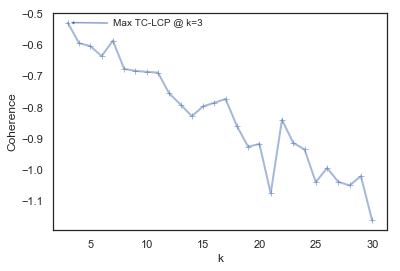

In [23]:
# Plot the coherence over the different 'k' selections
fig, ax = plt.subplots()
ax.plot(list(range(3, end_k+1)), coherencenmf, 'b+-', linewidth=2, label='UMass Coherency', alpha=0.5, markevery=1)
ax.set_xlabel('k')
ax.set_ylabel('Coherence')
ax.annotate('Max TC-LCP @ k=3', 
             xy=(3, -0.53001054467878117),  
             xycoords='data',
             xytext=(7, -0.54),
             arrowprops=dict(arrowstyle="simple"))
plt.savefig('images/UMassNMF.png', dpi=300)
plt.show()

Based on the three extrinsic coherency measures using the FOMC minutes as a background corpus, there is a consensus to estimate the model with k=3 as this gives the highest level of coherency. Therefore, we perform NMF with three components below and look to give an interpretation of these topics.

In [24]:
best_nmf = NMF(n_components=3, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf)
print_top_words(best_nmf, tfidf_feature_names_n1, 15)
best_topics=print_topics(best_nmf, tfidf_feature_names_n1, 15, 3)

Topic #0: inflation longer labor term condition policy price security fund run employment pace percent range agency
Topic #1: board growth approved action basis point discount reserve sustainable productivity belief risk demand price available
Topic #2: security credit financial reserve recovery level exceptionally purchase continue promote subdued facility billion condition housing



I believe that the topic model performed well in the analysis of the FOMC statements as each topic is clearly interpretable. The first topic represents "policy objectives" as it includes descriptors like inflation, security, employment, and price. These are words related to the Federal Reserve's explicit mandates. The second topic is related to "monetary policy tools and targets." Finally, the third topic is related to "financial markets." These are three topics that are useful for further analysis.

In [25]:
# Extract the weights for the model for later regression analysis.
W = best_nmf.fit_transform(X_tfidf) # topic-document weights
H = best_nmf.components_ # word-topic weights

In [26]:
# Dimensions of the W matrix
W.shape

(159, 3)

In [27]:
H.shape

(3, 552)

## Part 5: Visualization of the NMF Topics

In this section, we plot the topic-document weights as a function of the document dates. This analysis serves the purpose of providing a time series of topic weights to see the intensity of topics over time. This analysis is useful to map historical events back to the output of the topic model as this will provide even more validity to the performance of these models.

In [28]:
# Create dates and NMF weight variables
nmf_theme1_weights = W[:,0]
nmf_theme2_weights = W[:,1]
nmf_theme3_weights = W[:,2]

In [29]:
# A function to plot the weights of the themes
def plot_theme_weights(weights, name, color):
    fig, ax = plt.subplots()
    ax.plot(x, weights, '{}-'.format(color), linewidth=2, label='topic 1', alpha=0.6)
    ax.set_ylabel('Weight')
    ax.axvspan(x[7], x[32], alpha=0.30, color='gray')
    ax.axvspan(x[65], x[105], alpha=0.30, color='gray')
    plt.savefig('images/{}.png'.format(name), dpi=300)
    plt.show()

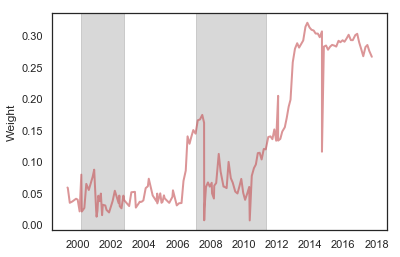

In [30]:
# Plot topic 1 weights as a time series
plot_theme_weights(weights=nmf_theme1_weights, name='NMFWeights1', color='r')

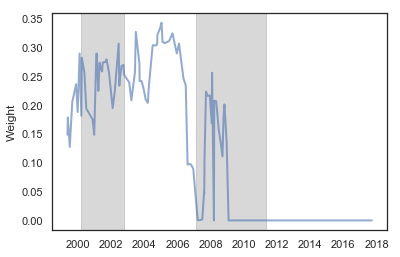

In [31]:
# Plot topic 2 weights as a time series
plot_theme_weights(weights=nmf_theme2_weights, name='NMFWeights2', color='b')

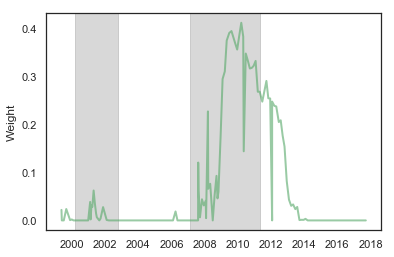

In [32]:
# Plot topic 3 weights as a time series
plot_theme_weights(weights=nmf_theme3_weights, name='NMFWeights3', color='g')

In [33]:
# Save the weights to a csv file
W = pd.DataFrame(W)
W.to_csv("results/weights.csv")

In this section, I create word clouds for the topics using the wordcloud package. This is good for representing topics in a coherent and clear way. It is also possible to use wordle.net, which is an online, interactive wordcloud creator. It provides more visually appealing wordclouds than the wordcloud package but is not capable of being integrated into Python. It is highly suggested to use that for creating wordclouds to be included in publications.

In [34]:
from wordcloud import WordCloud

In [35]:
def create_wordcloud(words, name):
    topic = WordCloud(ranks_only=True, max_font_size=40, background_color="white").generate(' '.join(words))
    plt.figure(figsize=(10, 6))
    plt.imshow(topic, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('images/{}.png'.format(name), dpi=300) # Save figure
    plt.show()

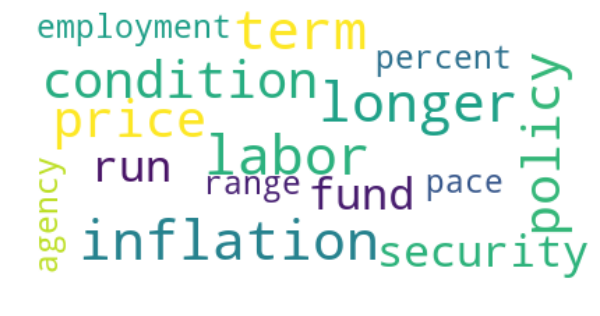

In [36]:
create_wordcloud(words=best_topics[0], name='NMF Theme 1')

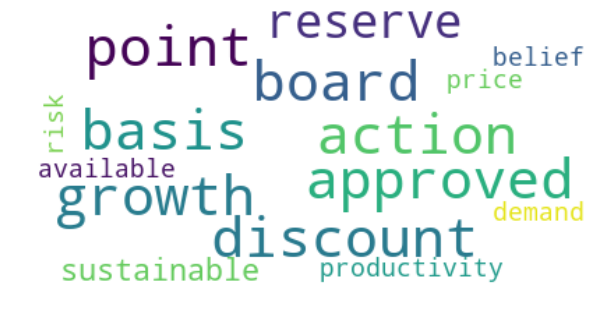

In [37]:
create_wordcloud(words=best_topics[1], name='NMF Theme 2')

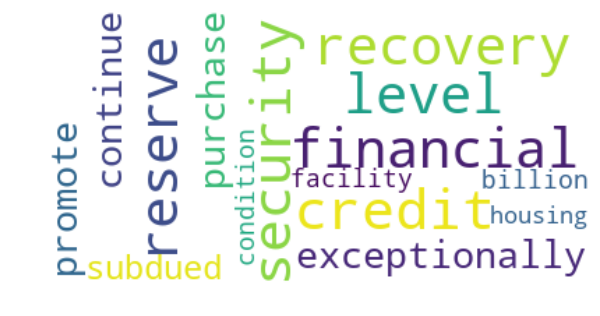

In [38]:
create_wordcloud(words=best_topics[2], name='NMF Theme 3')

## Part 6: Topic Modeling using Latent Dirichelet Allocation

<img src="images/LDA.jpg" alt="Visualization of LDA algorithm" title="Latent Dirichlet Allocation" />

Latent Dirichlet Allocation (LDA) is a probabilistic topic model. What this means is that LDA depends on probabilities to estimate the the parameters of interest. In this model we estimate two key parameters of interest: $\theta_d$ and $\beta_k$.

$\theta_d$ is the analog of the $W$ matrix in NMF and looks at the topic share in the document $d$, while $\beta_k$ is the analog of the $H$ matrix in NMF and estimates the weights of the terms in the topics.

Details about LDA can be found in the original paper by Blei et al. (2003).

In [39]:
# Import LDA model
from sklearn.decomposition import LatentDirichletAllocation

In [40]:
# Parameter selection using intrinsic coherence measure, u_mass
coherencelda=[]
end_k = 30
for k in range(3,end_k+1):
    n_components=k
    ldamodel = LatentDirichletAllocation(doc_topic_prior = 50/n_components, topic_word_prior = 0.025, n_components=n_components, max_iter=10, learning_method='batch', random_state=0).fit(X_tfidf)
    topics=print_topics(ldamodel, tfidf_feature_names_n1, 15, n_components)
    cm_LDA = models.coherencemodel.CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherencelda.append(cm_LDA.get_coherence())
    print('k= %d' % k)
    print_top_words(ldamodel, tfidf_feature_names_n1, 15)
print(coherencelda)

k= 3
Topic #0: inflation point longer policy term board toward maintain security basis accommodative growth however maximum month
Topic #1: percent inflation continue level development security outlook approved productivity purchase sustainable housing growth pace continues
Topic #2: inflation time price information expected condition belief risk today may mortgage consistent reserve accommodation potential

k= 4
Topic #0: inflation longer toward basis accommodative month policy run however maintain board resource maximum security billion
Topic #1: percent continue development inflation pace continues security purchase agency productivity business housing keep growth decline
Topic #2: inflation expected risk time information condition today belief consistent price since may credit fund accommodation
Topic #3: level term inflation moderate measure economy mortgage remains available approved underlying indicator reserve recent decided

k= 5
Topic #0: longer toward inflation accommodative

k= 13
Topic #0: longer maximum toward accommodative policy long adjustment incoming current however inflation louis weakness providing agency
Topic #1: agency percent continue productivity anticipates business decline sustainable reflecting rise roughly chicago attainment labor principal
Topic #2: consistent information belief fund spending potential holding governor may dual expected time today still debt
Topic #3: level available indicator term underlying expectation appropriate economy monitor moderate program commodity nonetheless unemployment measure
Topic #4: decided remain financial increase housing run accommodation year lower foreseeable appears next san activity change
Topic #5: outlook risk maintain demand condition future taking promote background credit including balanced reduction resource consumer
Topic #6: security continues remains pressure inflation expects labor somewhat effect expand financial francisco continued take firming
Topic #7: growth purchase approved reser

k= 19
Topic #0: maximum longer accommodative policy long adjustment incoming current agency inflation louis providing size keeping statutory
Topic #1: continue percent agency productivity business reflecting rise roughly facility view tight chicago gramlich improve inflationary
Topic #2: consistent information holding belief may potential dual time still fixed timing though dallas account strengthen
Topic #3: level available underlying indicator appropriate unemployment economy commodity term monitor received bies substantial highly act
Topic #4: remain decided accommodation lower foreseeable year keep next san activity change appears increase liquidity gradually
Topic #5: maintain demand future condition resource including balanced reduction consumer indicates even weak term heightened become
Topic #6: security pressure remains continued continues expects somewhat expand francisco inflation take generate data measured edward
Topic #7: growth approved reserve purchase since monetary ta

k= 23
Topic #0: maximum accommodative longer policy adjustment incoming current louis providing keeping statutory vice agency solid trend
Topic #1: percent continue agency productivity business rise roughly york facility tight gramlich improve inflationary import easing
Topic #2: consistent information belief may dual potential holding still today fixed timing dallas account employ march
Topic #3: level available underlying economy monitor commodity received unemployment discount bies substantial highly act extent inventory
Topic #4: remain decided accommodation lower foreseeable next san year change appears liquidity gradually increase olson activity
Topic #5: maintain demand future resource condition including balanced reduction consumer even heightened become sustain aggregate sign
Topic #6: pressure remains continues continued somewhat expand francisco take generate inflation data security measured edward realized
Topic #7: growth approved purchase since reserve target monetary cir

k= 27
Topic #0: maximum accommodative adjustment incoming current louis providing longer keeping policy statutory vice solid trend ensure
Topic #1: continue percent agency productivity business york rise roughly facility tight gramlich inflationary import easing kohn
Topic #2: consistent information belief may potential dual still holding today fixed dallas account governor mainly already
Topic #3: level available underlying economy monitor unemployment commodity received bies substantial highly act extent inventory intermeeting
Topic #4: remain decided accommodation lower foreseeable san year next change liquidity gradually olson gain closely expanding
Topic #5: maintain demand future resource including balanced reduction consumer even heightened become sustain aggregate sign relative
Topic #6: pressure continues continued somewhat expand take generate inflation data francisco security measured realized provide last
Topic #7: growth purchase approved target since circumstance gradual 

k= 30
Topic #0: accommodative adjustment incoming current louis longer providing keeping vice solid trend ensure transitory relatively march
Topic #1: continue agency percent business productivity york rise roughly facility tight gramlich inflationary import easing together
Topic #2: consistent information belief may potential dual still fixed dallas account today mainly governor already significantly
Topic #3: level available underlying economy monitor unemployment commodity received bies substantial highly act extent inventory intermeeting
Topic #4: remain decided accommodation lower year san next change liquidity gradually appears olson gain closely expanding
Topic #5: maintain demand future resource including reduction consumer even heightened become sustain aggregate sign relative equipment
Topic #6: pressure continues somewhat generate data francisco security measured realized provide last inflation robert composition reinvesting
Topic #7: growth purchase since target circumstanc

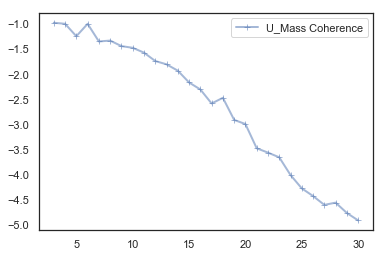

In [41]:
# Plot the coherence over the different 'k' selections
fig, ax = plt.subplots()
ax.plot(list(range(3, end_k+1)), coherencelda, 'b+-', linewidth=2, label='U_Mass Coherence', alpha=0.5, markevery=1)
ax.legend()
plt.show()

In [43]:
lda = LatentDirichletAllocation(doc_topic_prior = 50/3, topic_word_prior = 0.025, n_components=3, max_iter=10, learning_method='batch', random_state=0).fit(X_tfidf)
print_top_words(lda, tfidf_feature_names_n1, 15)
lda_topics=print_topics(lda, tfidf_feature_names_n1, 15, 3)

Topic #0: inflation point longer policy term board toward maintain security basis accommodative growth however maximum month
Topic #1: percent inflation continue level development security outlook approved productivity purchase sustainable housing growth pace continues
Topic #2: inflation time price information expected condition belief risk today may mortgage consistent reserve accommodation potential



## Part 7: Visualization of the LDA Topics

In [44]:
# Get probabilities from LDA model
P = lda.transform(X_tfidf) # Get a topic-document probability matrix
P

array([[0.33777447, 0.32967423, 0.33255129],
       [0.32936235, 0.3234319 , 0.34720575],
       [0.33373543, 0.33748509, 0.32877948],
       [0.330034  , 0.32884474, 0.34112125],
       [0.32729878, 0.33382137, 0.33887985],
       [0.33662436, 0.33184858, 0.33152706],
       [0.33403838, 0.33106911, 0.33489251],
       [0.31993657, 0.34812843, 0.33193499],
       [0.33718107, 0.32952369, 0.33329524],
       [0.3318337 , 0.32639804, 0.34176826],
       [0.32351835, 0.33771581, 0.33876584],
       [0.32777877, 0.33237648, 0.33984475],
       [0.3241819 , 0.33598055, 0.33983755],
       [0.34206989, 0.3213574 , 0.33657271],
       [0.32741741, 0.33062326, 0.34195933],
       [0.33885397, 0.32657124, 0.3345748 ],
       [0.33245646, 0.32951493, 0.33802861],
       [0.3292247 , 0.33629833, 0.33447697],
       [0.32977747, 0.33254611, 0.33767642],
       [0.33866993, 0.33140288, 0.32992719],
       [0.34055666, 0.32654141, 0.33290193],
       [0.32981244, 0.33591232, 0.33427524],
       [0.

In [45]:
# Create variables of probabilities
lda_theme1_probabilities = P[:,0]
lda_theme2_probabilities = P[:,1]
lda_theme3_probabilities = P[:,2]

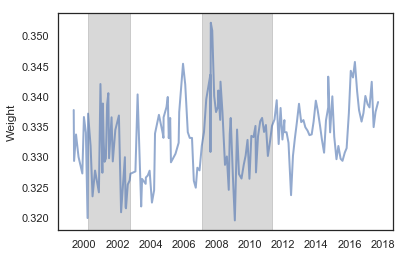

In [46]:
# Plot topic 1 probabilities as a time series
plot_theme_weights(weights=lda_theme1_probabilities, name='LDAProbabilities1', color='b')

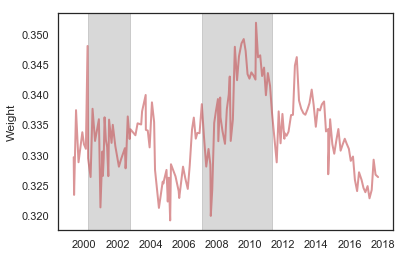

In [47]:
# Plot topic 2 probabilities as a time series
plot_theme_weights(weights=lda_theme2_probabilities, name='LDAProbabilities2', color='r')

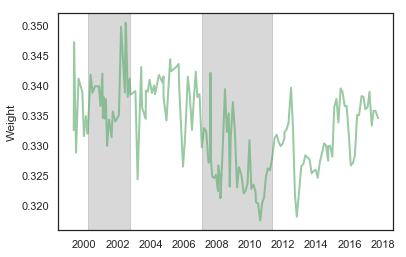

In [48]:
# Plot topic 3 probabilities as a time series
plot_theme_weights(weights=lda_theme3_probabilities, name='LDAProbabilities3', color='g')

In [49]:
# Save lda probabilities
P = pd.DataFrame(P)
P.to_csv("results/probabilities.csv")

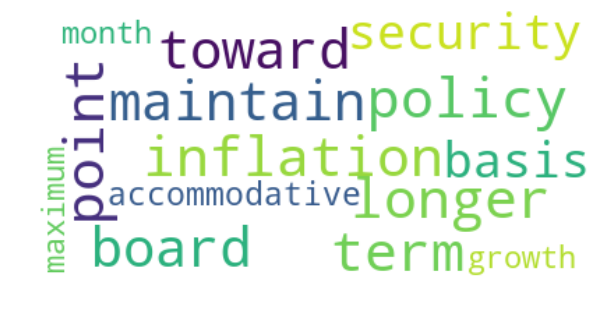

In [50]:
create_wordcloud(words=lda_topics[0], name='LDA Theme 1')

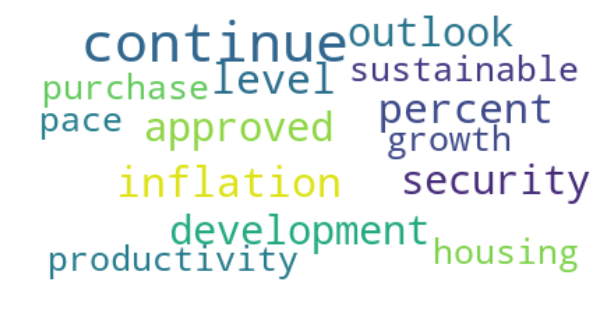

In [51]:
create_wordcloud(words=lda_topics[1], name='LDA Theme 2')

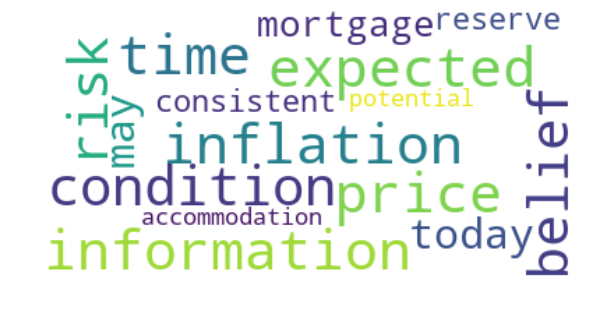

In [52]:
create_wordcloud(words=lda_topics[2], name='LDA Theme 3')

### Brief Comparison of LDA and NMF Coherency

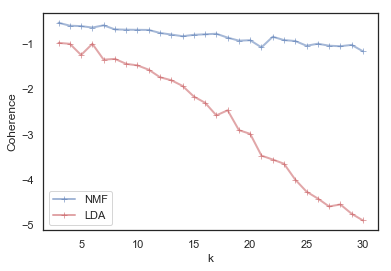

In [53]:
fig, ax = plt.subplots()
ax.plot(list(range(3, 30+1)), coherencenmf, 'b+-', linewidth=2, label='NMF', alpha=0.5, markevery=1)
ax.plot(list(range(3, 30+1)), coherencelda, 'r+-', linewidth=2, label='LDA', alpha=0.5, markevery=1)
ax.legend()
ax.set_ylabel('Coherence')
ax.set_xlabel('k')
plt.savefig('images/nmf_lda_coherence.png', dpi=300)
plt.show()

## Part 8: Establishing Polarity in FOMC Statements

In this section, I will estabish the polarity/sentiment of the FOMC statements. I will use a dictionary-based method that uses the Loughran and McDonald (2011) financial dictionary. This dataset is advantageous as it is a discipline-specific dictionary which is more relevant to central banking language and also contains terminology that would be familiar to financial market participants. Additionally, this provides us a systematic benchmark for establishing polarity that does not require us to choose a list of words that are relevant, which would influence the outcome of our models. The categories are entitled 'negative', 'positive', 'uncertainty', 'litigious', 'modal', and 'constraining.'

The master dictionary and list of words by sentiment can be found at this [website](http://sraf.nd.edu/textual-analysis/resources/).

In [54]:
# Read in pdf file of the list of negative financial terms
pdfFileObj = open('dictionaries/LM_Negative.pdf','rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
pdfReader.numPages

52

In [55]:
# Collect words from each page and lowercase them
negative=[]
for pageNum in range(0, pdfReader.numPages):
    pageObj = pdfReader.getPage(pageNum)
    negative.append(CountVectorizer().build_tokenizer()(pageObj.extractText().lower()))
negative

[['loughran',
  'mcdonald',
  'sentiment',
  'word',
  'lists',
  'negative',
  'abandon',
  'abandoned',
  'abandoning',
  'abandonment',
  'abandonments',
  'abandons',
  'abdicated',
  'abdicates',
  'abdicating',
  'abdication',
  'abdications',
  'aberrant',
  'aberration',
  'aberrational',
  'aberrations',
  'abetting',
  'abnormal',
  'abnormalities',
  'abnormality',
  'abnormally',
  'abolish',
  'abolished',
  'abolishes',
  'abolishing',
  'abrogate',
  'abrogated',
  'abrogates',
  'abrogating',
  'abrogation',
  'abrogations',
  'abrupt',
  'abruptly',
  'abruptness',
  'absence',
  'absences',
  'absenteeism',
  'abuse',
  'abused',
  'abuses',
  'abusing',
  'abusive',
  'abusively',
  'abusiveness',
  'accident'],
 ['accidental',
  'accidentally',
  'accidents',
  'accusation',
  'accusations',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  'acquiesce',
  'acquiesced',
  'acquiesces',
  'acquiescing',
  'acquit',
  'acquits',
  'acquittal',
  'acquittals',
  'ac

In [56]:
# delete the first six terms that are simply part of the list description
del negative[0][0:6]
negative

[['abandon',
  'abandoned',
  'abandoning',
  'abandonment',
  'abandonments',
  'abandons',
  'abdicated',
  'abdicates',
  'abdicating',
  'abdication',
  'abdications',
  'aberrant',
  'aberration',
  'aberrational',
  'aberrations',
  'abetting',
  'abnormal',
  'abnormalities',
  'abnormality',
  'abnormally',
  'abolish',
  'abolished',
  'abolishes',
  'abolishing',
  'abrogate',
  'abrogated',
  'abrogates',
  'abrogating',
  'abrogation',
  'abrogations',
  'abrupt',
  'abruptly',
  'abruptness',
  'absence',
  'absences',
  'absenteeism',
  'abuse',
  'abused',
  'abuses',
  'abusing',
  'abusive',
  'abusively',
  'abusiveness',
  'accident'],
 ['accidental',
  'accidentally',
  'accidents',
  'accusation',
  'accusations',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  'acquiesce',
  'acquiesced',
  'acquiesces',
  'acquiescing',
  'acquit',
  'acquits',
  'acquittal',
  'acquittals',
  'acquitte',
  'acquitting',
  'adulterate',
  'adulterated',
  'adulterating',
  

In [57]:
# Calculate the sum of negative terms within each statement
neg_sum = list(range(0, len(statements)))
for i in range(0, len(statements)):
    neg_count = 0
    fomc = statements[i]
    for word in fomc:
        for neg in negative:
            if((word in set(neg)) == True):
                neg_count += 1
    neg_sum[i] = neg_count

In [58]:
# Transform negative sum list into a numpy array and calculate percentage of negativity
neg_sum = np.asarray(neg_sum)
negativity_proportion = neg_sum/doc_length

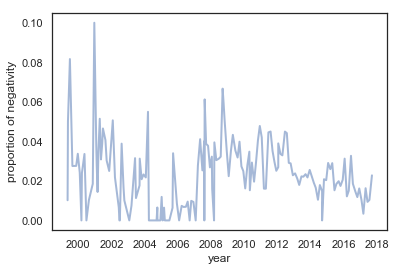

In [59]:
# Plot the proportion of negativity as a time series
fig, ax = plt.subplots()
ax.plot(x, negativity_proportion, 'b-', linewidth=2, label='Negativity', alpha=0.5, markevery=1)
ax.set_xlabel('year')
ax.set_ylabel('proportion of negativity')
plt.show()

In [60]:
# Export the proportion of negativity to csv file
NegProp = pd.DataFrame(negativity_proportion)
NegProp.to_csv("results/negativity.csv")

## Part 9: Calculating Uncertainty in FOMC Statements

In this section, I look to calculate a level of uncertainty in each document. Similar to the previous section, I use a dictionary-based method incorporating the sentimental list of words provided in the financial dictionary by Loughran and McDonald (2011). This allows me to come up with a measure of uncertainty within the statements. The literature looks at uncertainty as a main contributor to financial market volatility, which is channeled into risk premia. Using this measure, we may look at the influence of uncertainty on volatility.

In [61]:
# Read in pdf file of list of uncertain financial terms
pdfFileObj2 = open('dictionaries/LM_Uncertainty.pdf','rb')
pdfReader2 = PyPDF2.PdfFileReader(pdfFileObj2)
pdfReader2.numPages

7

In [62]:
# Collect the uncertainty terms on each page into a list
uncertainty=[]
for pageNum in range(0, pdfReader2.numPages):
    pageObj2 = pdfReader2.getPage(pageNum)
    uncertainty.append(CountVectorizer().build_tokenizer()(pageObj2.extractText().lower()))
uncertainty

[['loughran',
  'mcdonald',
  'sentiment',
  'word',
  'lists',
  'uncertainty',
  'abeyance',
  'abeyances',
  'almost',
  'alteration',
  'alterations',
  'ambiguities',
  'ambiguity',
  'ambiguous',
  'anomalies',
  'anomalous',
  'anomalously',
  'anomaly',
  'anticipate',
  'anticipated',
  'anticipates',
  'anticipating',
  'anticipation',
  'anticipations',
  'apparent',
  'apparently',
  'appear',
  'appeared',
  'appearing',
  'appears',
  'approximate',
  'approximated',
  'approximately',
  'approximates',
  'approximating',
  'approximation',
  'approximations',
  'arbitrarily',
  'arbitrariness',
  'arbitrary',
  'assume',
  'assumed',
  'assumes',
  'assuming',
  'assumption',
  'assumptions',
  'believe',
  'believed',
  'believes',
  'believing'],
 ['cautious',
  'cautiously',
  'cautiousness',
  'clarification',
  'clarifications',
  'conceivable',
  'conceivably',
  'conditional',
  'conditionally',
  'confuses',
  'confusing',
  'confusingly',
  'confusion',
  'conti

In [63]:
# Delete the first six terms that are simply part of the list description
del uncertainty[0][0:6]
uncertainty

[['abeyance',
  'abeyances',
  'almost',
  'alteration',
  'alterations',
  'ambiguities',
  'ambiguity',
  'ambiguous',
  'anomalies',
  'anomalous',
  'anomalously',
  'anomaly',
  'anticipate',
  'anticipated',
  'anticipates',
  'anticipating',
  'anticipation',
  'anticipations',
  'apparent',
  'apparently',
  'appear',
  'appeared',
  'appearing',
  'appears',
  'approximate',
  'approximated',
  'approximately',
  'approximates',
  'approximating',
  'approximation',
  'approximations',
  'arbitrarily',
  'arbitrariness',
  'arbitrary',
  'assume',
  'assumed',
  'assumes',
  'assuming',
  'assumption',
  'assumptions',
  'believe',
  'believed',
  'believes',
  'believing'],
 ['cautious',
  'cautiously',
  'cautiousness',
  'clarification',
  'clarifications',
  'conceivable',
  'conceivably',
  'conditional',
  'conditionally',
  'confuses',
  'confusing',
  'confusingly',
  'confusion',
  'contingencies',
  'contingency',
  'contingent',
  'contingently',
  'contingents',
  

In [64]:
# Calculate the sum of uncertain terms within each statement
uncertain_sum = list(range(0, len(statements)))
for i in range(0, len(statements)):
    uncertain_count = 0
    fomc = statements[i]
    for word in fomc:
        for unc in uncertainty:
            if((word in set(unc)) == True):
                uncertain_count += 1
    uncertain_sum[i] = uncertain_count

In [66]:
# Transform the uncertainty sum list into a numpy array and calculate percentage of uncertainty
uncertain_sum = np.asarray(uncertain_sum)
uncertainty_proportion = uncertain_sum/doc_length

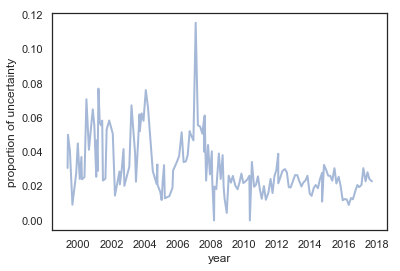

In [67]:
# Plot the proportion of uncertainty as a time series
fig, ax = plt.subplots()
ax.plot(x, uncertainty_proportion, 'b-', linewidth=2, label='Uncertainty', alpha=0.5, markevery=1)
ax.set_xlabel('year')
ax.set_ylabel('proportion of uncertainty')
plt.show()

In [68]:
# Export the uncertainty proportion to a csv file
UncertProp = pd.DataFrame(uncertainty_proportion)
UncertProp.to_csv("results/uncertainty.csv")

## Part 10: Regression Analysis

In [69]:
from pandas_datareader import data
import statsmodels.api as sm

In [70]:
# Want to look at influence of changes in topics
W_diff = W.diff() # w_diff = w(t) - w(t-1)
W_diff = np.asarray(W_diff)

In [71]:
# Set end dates
start_date = x[0]
end_date = x[-1]

In [73]:
vix = data.get_data_yahoo('^VIX', start_date, end_date)
vix.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-05-10,26.980000,25.730000,26.389999,26.620001,0,26.620001
1999-05-11,26.209999,25.330000,25.860001,25.620001,0,25.620001
1999-05-12,27.080000,26.059999,26.709999,26.129999,0,26.129999
1999-05-13,25.559999,24.760000,25.559999,25.020000,0,25.020000
1999-05-14,27.780001,26.480000,26.590000,26.860001,0,26.860001


In [74]:
# Set dependent variable as VIX at close
y = vix['Close']

In [75]:
# Construct X matrix
vix_dates = vix.index
statement_dates = x
X = np.zeros((len(y), W.shape[1]))
for i, vix_date in enumerate(vix_dates):
    for j, statement_date in enumerate(statement_dates):
        if int(date2num(vix_date)) == int(date2num(statement_date)):
            X[i,:] = W_diff[j,:]

In [76]:
# Estimate OLS
X_cons = sm.add_constant(X) # add column of ones/intercept
model = sm.OLS(y[1:], X_cons[1:,:]) # drop row with NaNs due to first differencing
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.021
Date:                Mon, 13 Jan 2020   Prob (F-statistic):              0.109
Time:                        17:19:11   Log-Likelihood:                -16505.
No. Observations:                4623   AIC:                         3.302e+04
Df Residuals:                    4619   BIC:                         3.304e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1363      0.126    159.188      0.0

### Finding:
In this extremely simple model, there evidence that more central bank __communication related to financial markets__ contributes to __increased stock market volatility__.

### Issue:
Model is underspecified and could be better. Many factors contribute to stock market volatility.